### Import

In [2]:
pip install ase

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import random
import numpy as np
import pandas as pd
from ase.io import read
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.auto import tqdm

np.set_printoptions(threshold=np.inf)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

### Pre-processing

In [6]:
train = read('./Train.xyz', format='extxyz', index=':') # 전체 데이터 불러오기
test = read('./Test.xyz', format='extxyz', index=':')
sample = pd.read_csv('./sample_submission.csv')

In [7]:
print(f"The number of data: {len(train)}")
train

The number of data: 1500


[Atoms(symbols='Hf32O64', pbc=True, cell=[10.07550514, 9.97216976, 10.40475547], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[11.06995848, 11.06995848, 11.37809456], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[12.2240691, 7.33391326, 14.31098868], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[11.0707505, 11.0707505, 11.0707505], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[11.06995848, 11.06995848, 11.37809456], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[11.08305576, 10.96938685, 11.44523113], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[11.0707505, 11.0707505, 11.0707505], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True, cell=[12.2240691, 7.33391326, 14.31098868], calculator=SinglePointCalculator(...)),
 Atoms(symbols='Hf32O64', pbc=True,

In [8]:
# Train 데이터를 train과 validation으로 분리
from sklearn.model_selection import train_test_split
train_data, val_data= train_test_split(train, test_size=0.2, random_state=42)

In [9]:
from scipy.spatial import distance_matrix
from ase.geometry import get_distances
# 새로운 피처 생성 함수들
# 각도 계산 함수 (결측값 방지)
def calculate_angle_with_pbc(p1, p2, p3, cell, pbc=True):
    # PBC를 적용한 좌표를 구함
    v1, _ = get_distances(np.array([p1]), np.array([p2]), cell=cell, pbc=pbc)
    v2, _ = get_distances(np.array([p2]), np.array([p3]), cell=cell, pbc=pbc)

    # v1, v2의 형태를 평평하게 하고 벡터를 추출
    v1 = v1[0][0]
    v2 = v2[0][0]

    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    if norm_v1 < 1e-6 or norm_v2 < 1e-6:
        return 0.0  # NaN 방지를 위해 0을 반환

    cosine_angle = np.dot(v1, v2) / (norm_v1 * norm_v2)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cosine_angle))
    return angle


# 이면체 각도 계산 함수 (PBC 적용)
def dihedral_angle_with_pbc(p1, p2, p3, p4, cell, pbc=True):
    b1, _ = get_distances(np.array([p1]), np.array([p2]), cell=cell, pbc=pbc)
    b2, _ = get_distances(np.array([p2]), np.array([p3]), cell=cell, pbc=pbc)
    b3, _ = get_distances(np.array([p3]), np.array([p4]), cell=cell, pbc=pbc)

    b1 = b1[0][0]
    b2 = b2[0][0]
    b3 = b3[0][0]

    n1 = np.cross(b1, b2)
    n2 = np.cross(b2, b3)

    norm_n1 = np.linalg.norm(n1)
    norm_n2 = np.linalg.norm(n2)

    if norm_n1 < 1e-6 or norm_n2 < 1e-6:
        return 0.0  # NaN 방지를 위해 0을 반환

    m1 = np.cross(n1, b2 / np.linalg.norm(b2))

    x = np.dot(n1, n2)
    y = np.dot(m1, n2)

    return np.degrees(np.arctan2(y, x))

def count_neighbors_with_pbc(positions, cell, cutoff=3.0, pbc=True):
    # PBC를 고려하여 원자 간 거리 계산
    dist_matrix, vectors = get_distances(positions, positions, cell=cell, pbc=pbc)
    
    # dist_matrix의 형태를 확인하여 거리 정보만 추출
    if dist_matrix.shape[2] != 3:
        raise ValueError("dist_matrix should have 3rd dimension of size 3 for xyz components")
    
    # 벡터를 거리로 변환
    distances = np.linalg.norm(dist_matrix, axis=2)
    
    np.fill_diagonal(distances, np.inf)  # 자기 자신과의 거리는 무한대로 설정
    neighbors = np.sum(distances < cutoff, axis=1) - 1  # 자신 제외
    return neighbors

# 원자 간 거리를 계산하는 함수
def calculate_distances_with_pbc(positions, cell, pbc=True):
    # ASE의 get_distances 함수를 사용하여 PBC를 고려한 거리 계산
    dist_matrix, _ = get_distances(positions, positions, cell=cell, pbc=pbc)

    # 거리 행렬에서 각 원자 쌍 간의 거리만 추출
    dist_matrix = np.sqrt(np.sum(dist_matrix ** 2, axis=2))

    np.fill_diagonal(dist_matrix, np.inf)  # 자기 자신과의 거리는 무한대로 설정
    closest_distances = np.min(dist_matrix, axis=1)
    return closest_distances


# 각도와 이면체 각도를 처리하는 함수
def replace_zero_with_mean(data):
    data = np.array(data)  # 리스트를 numpy array로 변환
    mean_value = np.mean(data[data > 0])  # 0이 아닌 값의 평균 계산
    data[data == 0] = mean_value  # 0 값을 평균값으로 대체
    return data.tolist()  # numpy array를 다시 리스트로 변환

In [10]:
sequence_train, symbols, train_positions_x, train_positions_y, train_positions_z, train_forces, train_energies,neighbor_counts, closest_distances =[], [], [], [], [], [], [], [], []
angles, dihedral_angles = [],[]
for i in range(len(train_data)):
    mole = train_data[i] # 각 분자
    cell = mole.get_cell()

    atoms = len(mole) # 원자 개수
    sequence_train.append(atoms)
    
    position = mole.get_positions() # 원자 위치 정보
    force = mole.get_forces() # label 1
    
    energy = mole.get_total_energy() # label 2
    train_energies.append(energy)

     # 이웃 원자 개수 계산
    neighbor_count = count_neighbors_with_pbc(position,cell)
    neighbor_counts.extend(neighbor_count)
        
 # 각도와 이면체 각도 계산
    for j in range(len(mole)):  # 모든 원자에 대해
        if j >= 1 and j < atoms - 1:  # 각도를 계산할 수 있는 경우 (원자 3개 필요)
            angle = calculate_angle_with_pbc(position[j-1], position[j], position[j+1],cell)
        else:
            angle = 0.0  # 기본값으로 0을 설정
        angles.append(angle)

        if j >= 2 and j < atoms - 2:  # 이면체 각도를 계산할 수 있는 경우 (원자 4개 필요)
            dihedral = dihedral_angle_with_pbc(position[j-2], position[j-1], position[j], position[j+1],cell)
        else:
            dihedral = 0.0  # 기본값으로 0을 설정
        dihedral_angles.append(dihedral)


    # 0 값을 평균값으로 대체
    angles = replace_zero_with_mean(angles)
    dihedral_angles = replace_zero_with_mean(dihedral_angles)
            # 원자 간 거리 계산
    closest_distances_list = calculate_distances_with_pbc(position,cell).tolist()  # 리스트로 변환
    closest_distances.extend(closest_distances_list)  # 리스트에 값 추가




    for j in range(len(mole)): # 각 원자에 대해
        train_positions_x.append(position[j][0])
        train_positions_y.append(position[j][1])
        train_positions_z.append(position[j][2])
        train_forces.append(force[j])

print(f"train_positions_x length: {len(train_positions_x)}")
print(f"train_positions_y length: {len(train_positions_y)}")
print(f"train_positions_z length: {len(train_positions_z)}")
print(f"train_forces length: {len(train_forces)}")
print(f"neighbor_counts length: {len(neighbor_counts)}")
print(f"angles length: {len(angles)}")
print(f"dihedral_angles length: {len(dihedral_angles)}")
print(f"closest_distances length: {len(closest_distances)}")

# # 부족한 값에 NaN 채우기
# required_length = len(train_positions_x)
# # # angles 배열이 짧을 경우 NaN으로 채우기
# if len(angles) < required_length:
#     angles.extend([np.mean(angles)] * (required_length - len(angles)))

# # dihedral_angles 배열이 짧을 경우 NaN으로 채우기
# if len(dihedral_angles) < required_length:
#     dihedral_angles.extend([np.mean(dihedral_angles)] * (required_length - len(dihedral_angles)))

train_df = pd.DataFrame({'position_x': train_positions_x, 
                         'position_y':train_positions_y, 
                         'position_z':train_positions_z, 
                         'force':train_forces,
                        'neighbor_count': neighbor_counts,  # 이웃 원자 개수 추가
                        'angle': angles,  # 각도 추가
                        'dihedral_angle': dihedral_angles,
                        'closest_distance': closest_distances  # 이면체 각도 추가
                        })        


train_positions_x length: 115200
train_positions_y length: 115200
train_positions_z length: 115200
train_forces length: 115200
neighbor_counts length: 115200
angles length: 115200
dihedral_angles length: 115200
closest_distances length: 115200


In [11]:
train_df

,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,3.396893,8.829709,7.691464,"[-0.28985941, 0.85350174, -5.07829368]",5,92.734736,80.426500,1.825582
1,5.832704,7.685400,4.421321,"[-0.42817584, 5.34562512, 1.83983188]",4,96.252095,80.426500,1.714732
2,10.404527,7.516713,8.776619,"[-0.93202857, -1.41141717, 0.41067321]",5,147.822854,-15.727954,2.008141
3,6.658308,7.611092,8.019703,"[-5.09921578, -0.77389718, -0.25370936]",5,91.658212,7.454451,1.821950
4,7.981478,8.422916,2.421269,"[1.30566613, 3.97447442, -1.69354644]",6,96.884044,59.053074,1.921819
...,...,...,...,...,...,...,...,...
115195,3.710855,10.704700,2.488768,"[1.46739834, 1.70785629, -2.1113748]",10,127.990477,-66.851140,2.087116
115196,9.178798,8.943130,10.692765,"[0.04464789, -0.54188175, -0.49488191]",6,90.574710,81.965126,1.948251
115197,9.745154,6.126706,1.812264,"[-1.55608995, 1.79120875, 1.35861819]",7,20.714368,-58.660125,2.024912
115198,8.735522,1.450940,4.887784,"[-1.72942859, -0.91480916, -0.27323517]",5,74.923922,90.611192,1.928140


In [12]:

# Validation 데이터 준비
sequence_val, val_positions_x, val_positions_y, val_positions_z, val_forces, val_energies,neighbor_counts_val, closest_distances_val = [],[], [], [], [], [], [], []
angles_val, dihedral_angles_val= [],[]
# angles_val, dihedral_angles_val = [],[]
for i in range(len(val_data)):
    mole = val_data[i]
    atoms = len(mole)
    sequence_val.append(atoms)
    position = mole.get_positions()
    force = mole.get_forces()
    energy = mole.get_total_energy() # label 2
    val_energies.append(energy)

        # 이웃 원자 개수 계산
    neighbor_count = count_neighbors_with_pbc(position,cell)
    neighbor_counts_val.extend(neighbor_count)

    # 각도와 이면체 각도 계산
    for j in range(len(mole)):  # 모든 원자에 대해
        if j >= 1 and j < atoms - 1:  # 각도를 계산할 수 있는 경우 (원자 3개 필요)
            angle = calculate_angle_with_pbc(position[j-1], position[j], position[j+1],cell)
        else:
            angle = 0.0  # 기본값으로 0을 설정
        angles_val.append(angle)

        if j >= 2 and j < atoms - 2:  # 이면체 각도를 계산할 수 있는 경우 (원자 4개 필요)
            dihedral = dihedral_angle_with_pbc(position[j-2], position[j-1], position[j], position[j+1],cell)
        else:
            dihedral = 0.0  # 기본값으로 0을 설정
        dihedral_angles_val.append(dihedral)

            # 0 값을 평균값으로 대체
    angles_val = replace_zero_with_mean(angles_val)
    dihedral_angles_val = replace_zero_with_mean(dihedral_angles_val)


              # 원자 간 거리 계산
    closest_distances_list = calculate_distances_with_pbc(position,cell).tolist()  # 리스트로 변환
    closest_distances_val.extend(closest_distances_list)  # 리스트에 값 추가

    for j in range(atoms):
        val_positions_x.append(position[j][0])
        val_positions_y.append(position[j][1])
        val_positions_z.append(position[j][2])
        val_forces.append(force[j])

print(f"train_positions_x length: {len(val_positions_x)}")
print(f"train_positions_y length: {len(val_positions_y)}")
print(f"train_positions_z length: {len(val_positions_z)}")
print(f"train_forces length: {len(val_forces)}")
print(f"neighbor_counts length: {len(neighbor_counts_val)}")
# print(f"angles length: {len(angles_val)}")
# print(f"dihedral_angles length: {len(dihedral_angles_val)}")
print(f"closest_distances length: {len(closest_distances_val)}")

# 부족한 값에 NaN 채우기
required_length = len(val_positions_x)
# # angles 배열이 짧을 경우 NaN으로 채우기
if len(angles_val) < required_length:
    angles_val.extend([np.mean(angles_val)] * (required_length - len(angles_val)))

# dihedral_angles 배열이 짧을 경우 NaN으로 채우기
if len(dihedral_angles_val) < required_length:
    dihedral_angles_val.extend([np.mean(dihedral_angles_val)] * (required_length - len(dihedral_angles_val)))

val_df = pd.DataFrame({
    'position_x': val_positions_x,
    'position_y': val_positions_y,
    'position_z': val_positions_z,
    'force': val_forces,
    'neighbor_count': neighbor_counts_val,  # 이웃 원자 개수 추가
    'angle': angles_val,  # 각도 추가
    'dihedral_angle': dihedral_angles_val,
    'closest_distance': closest_distances_val  # 이면체 각도 추가
})

train_positions_x length: 28800
train_positions_y length: 28800
train_positions_z length: 28800
train_forces length: 28800
neighbor_counts length: 28800
closest_distances length: 28800


In [13]:
val_df

,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,5.415821,6.623271,9.280295,"[1.67585631, 1.08030121, -5.61627497]",5,95.489592,97.612034,1.982761
1,0.590697,2.305846,1.784735,"[1.22788324, 7.59955364, -2.4058393]",5,123.064483,97.612034,1.866654
2,2.780320,6.854134,3.754616,"[5.41077205, 3.57867253, -1.3495054]",12,155.711106,64.333172,1.855688
3,2.795055,4.088505,2.722087,"[0.75679699, 5.11372434, 2.56980597]",15,59.270341,-110.536450,1.948627
4,3.917451,3.492605,0.173156,"[-0.72083412, -4.3361694, -1.72924391]",4,65.865646,47.370607,1.862408
...,...,...,...,...,...,...,...,...
28795,9.793515,0.751277,6.002652,"[-1.25875841, -6.02879618, 1.75122266]",7,124.388982,139.799698,1.851588
28796,9.647904,4.467099,5.364594,"[0.29002059, 1.51172089, -1.16399642]",9,73.648294,-38.876120,2.096363
28797,2.787859,6.379212,7.222255,"[-0.30821263, 3.39252611, 0.73336493]",9,133.610142,-87.848085,2.165416
28798,1.221499,3.964615,1.667194,"[1.20011951, -0.09495639, 0.41954826]",16,48.653807,90.753618,0.429809


In [14]:
sequence_test, positions_x, positions_y, positions_z,neighbor_counts_test, closest_distances_test = [],[], [], [], [], []
angles_test, dihedral_angles_test = [],[]

for i in range(len(test)):
    mole = test[i] # 각 분자

    atoms = len(mole) # 원자 개수
    sequence_test.append(atoms)

    position = mole.get_positions() # 원자 위치 정보

        # 이웃 원자 개수 계산
    neighbor_count = count_neighbors_with_pbc(position,cell)
    neighbor_counts_test.extend(neighbor_count)

# 각도와 이면체 각도 계산
    for j in range(len(mole)):  # 모든 원자에 대해
        if j >= 1 and j < atoms - 1:  # 각도를 계산할 수 있는 경우 (원자 3개 필요)
            angle = calculate_angle_with_pbc(position[j-1], position[j], position[j+1],cell)
        else:
            angle = 0.0  # 기본값으로 0을 설정
        angles_test.append(angle)

        if j >= 2 and j < atoms - 2:  # 이면체 각도를 계산할 수 있는 경우 (원자 4개 필요)
            dihedral = dihedral_angle_with_pbc(position[j-2], position[j-1], position[j], position[j+1],cell)
        else:
            dihedral = 0.0  # 기본값으로 0을 설정
        dihedral_angles_test.append(dihedral)

    angles_test = replace_zero_with_mean(angles_test)
    dihedral_angles_test = replace_zero_with_mean(dihedral_angles_test)

            # 원자 간 거리 계산
    closest_distances_list = calculate_distances_with_pbc(position,cell).tolist()  # 리스트로 변환
    closest_distances_test.extend(closest_distances_list)  # 리스트에 값 추가


    for j in range(len(mole)): # 각 원자에 대해
        positions_x.append(position[j][0])
        positions_y.append(position[j][1])
        positions_z.append(position[j][2])

print(f"train_positions_x length: {len(positions_x)}")
print(f"train_positions_y length: {len(positions_y)}")
print(f"train_positions_z length: {len(positions_z)}")
print(f"neighbor_counts length: {len(neighbor_counts_test)}")
print(f"angles length: {len(angles_test)}")
print(f"dihedral_angles length: {len(dihedral_angles_test)}")
print(f"closest_distances length: {len(closest_distances_test)}")

# # 부족한 값에 NaN 채우기
required_length = len(positions_x)
# angles 배열이 짧을 경우 NaN으로 채우기
if len(angles_test) < required_length:
    angles_test.extend([np.mean(angles_test)] * (required_length - len(angles_test)))

# dihedral_angles 배열이 짧을 경우 NaN으로 채우기
if len(dihedral_angles_test) < required_length:
    dihedral_angles_test.extend([np.mean(dihedral_angles_test)] * (required_length - len(dihedral_angles_test)))

test_df = pd.DataFrame({'position_x': positions_x, 
                        'position_y':positions_y, 
                        'position_z':positions_z, 
                        'force':None,
                        'neighbor_count': neighbor_counts_test,  # 이웃 원자 개수 추가
                        'angle': angles_test,  # 각도 추가
                        'dihedral_angle': dihedral_angles_test,
                        'closest_distance': closest_distances_test   # 이면체 각도 추가
                        })
test_df.head()


train_positions_x length: 288000
train_positions_y length: 288000
train_positions_z length: 288000
neighbor_counts length: 288000
angles length: 288000
dihedral_angles length: 288000
closest_distances length: 288000


,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,3.434929,4.600871,6.329366,None,4,90.676068,97.216677,1.963911
1,10.632562,3.276950,6.474922,None,5,132.475186,97.216677,1.986261
2,3.438480,2.931912,2.621738,None,5,106.742404,56.859881,1.961275
3,3.042868,6.105789,3.277181,None,5,42.596480,135.271599,1.992429
4,2.527150,0.367885,0.119567,None,6,29.518468,179.538191,1.965436


In [15]:
test_df

,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,3.434929,4.600871,6.329366,None,4,90.676068,97.216677,1.963911
1,10.632562,3.276950,6.474922,None,5,132.475186,97.216677,1.986261
2,3.438480,2.931912,2.621738,None,5,106.742404,56.859881,1.961275
3,3.042868,6.105789,3.277181,None,5,42.596480,135.271599,1.992429
4,2.527150,0.367885,0.119567,None,6,29.518468,179.538191,1.965436
...,...,...,...,...,...,...,...,...
287995,3.216771,9.309317,3.186366,None,7,57.462000,12.593215,1.956207
287996,4.280226,9.151952,5.748076,None,5,4.759560,-157.501611,1.903413
287997,6.074630,8.800569,9.277000,None,8,105.267343,-17.355251,1.936684
287998,10.822084,8.407604,4.906599,None,10,79.748726,90.021310,2.164426


In [16]:
train_df

,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,3.396893,8.829709,7.691464,"[-0.28985941, 0.85350174, -5.07829368]",5,92.734736,80.426500,1.825582
1,5.832704,7.685400,4.421321,"[-0.42817584, 5.34562512, 1.83983188]",4,96.252095,80.426500,1.714732
2,10.404527,7.516713,8.776619,"[-0.93202857, -1.41141717, 0.41067321]",5,147.822854,-15.727954,2.008141
3,6.658308,7.611092,8.019703,"[-5.09921578, -0.77389718, -0.25370936]",5,91.658212,7.454451,1.821950
4,7.981478,8.422916,2.421269,"[1.30566613, 3.97447442, -1.69354644]",6,96.884044,59.053074,1.921819
...,...,...,...,...,...,...,...,...
115195,3.710855,10.704700,2.488768,"[1.46739834, 1.70785629, -2.1113748]",10,127.990477,-66.851140,2.087116
115196,9.178798,8.943130,10.692765,"[0.04464789, -0.54188175, -0.49488191]",6,90.574710,81.965126,1.948251
115197,9.745154,6.126706,1.812264,"[-1.55608995, 1.79120875, 1.35861819]",7,20.714368,-58.660125,2.024912
115198,8.735522,1.450940,4.887784,"[-1.72942859, -0.91480916, -0.27323517]",5,74.923922,90.611192,1.928140


In [17]:
# train_forces가 list인 경우
train_forces = np.array(train_forces)

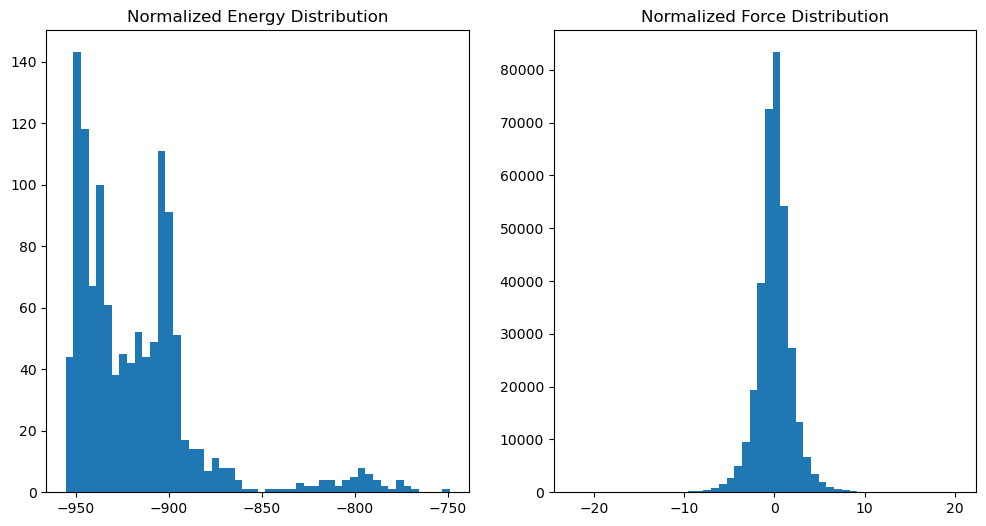

In [18]:
import matplotlib.pyplot as plt

# 정규화된 에너지와 힘 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_energies, bins=50)  # 정규화된 train_energies 사용
plt.title("Normalized Energy Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.concatenate([train_forces[:, i] for i in range(3)]), bins=50)  # 정규화된 train_forces 사용
plt.title("Normalized Force Distribution")

plt.show()


데이터 정규화

In [19]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# 데이터 정규화 (표준화 적용)
energy_scaler = RobustScaler()
force_scaler = StandardScaler()
position_scaler = RobustScaler()
scaler = RobustScaler()

train_positions = np.vstack((train_df[['position_x', 'position_y', 'position_z']].values))
val_positions = np.vstack((val_df[['position_x', 'position_y', 'position_z']].values))
test_positions = np.vstack((test_df[['position_x', 'position_y', 'position_z']].values))
# 각 데이터에 대해 스케일 적용
train_positions_scaled = position_scaler.fit_transform(train_positions)
val_positions_scaled = position_scaler.transform(val_positions)
test_positions_scaled = position_scaler.transform(test_positions)

# 에너지와 힘에 대해 각각의 스케일러 적용
train_energies = energy_scaler.fit_transform(np.array(train_energies).reshape(-1, 1)).flatten()
train_forces = np.array(train_forces)
train_forces = force_scaler.fit_transform(train_forces)

val_energies = energy_scaler.transform(np.array(val_energies).reshape(-1, 1)).flatten()
val_forces = np.array(val_forces)
val_forces = force_scaler.transform(val_forces)

#추가한 피쳐 정규화
# Train 데이터 정규화
train_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']] = scaler.fit_transform(
    train_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']])

# Validation 데이터 정규화 (Train 데이터로 학습된 스케일러 사용)
val_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']] = scaler.transform(
    val_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']])

test_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']] = scaler.transform(
    test_df[['neighbor_count', 'closest_distance','angle','dihedral_angle']])


train_df[['position_x', 'position_y', 'position_z']] = train_positions_scaled
train_df['force'] = list(train_forces)

val_df[['position_x', 'position_y', 'position_z']] = val_positions_scaled
val_df['force'] = list(val_forces)

test_df[['position_x', 'position_y', 'position_z']] = test_positions_scaled
test_df['force'] = None


train_df

,position_x,position_y,position_z,force,neighbor_count,angle,dihedral_angle,closest_distance
0,-0.348473,0.775757,0.357094,"[-0.14981823630956442, 0.44600123624287996, -2...",-0.50,0.069515,0.407215,-1.099663
1,0.098688,0.547709,-0.216258,"[-0.22130849375820014, 2.793393386251201, 0.95...",-0.75,0.129238,0.407215,-1.970735
2,0.937973,0.514091,0.547353,"[-0.481729915738929, -0.737548817927583, 0.212...",-0.50,1.004885,-0.137260,0.334904
3,0.250250,0.532900,0.414644,"[-2.635583123774749, -0.4044080527691283, -0.1...",-0.50,0.051236,-0.005989,-1.128204
4,0.493155,0.694687,-0.566926,"[0.6748454108108357, 2.0768884914861747, -0.87...",-0.25,0.139968,0.286188,-0.343424
...,...,...,...,...,...,...,...,...
115195,-0.290837,1.149421,-0.555092,"[0.7584383529554299, 0.8924504973924906, -1.09...",0.75,0.668141,-0.426744,0.955503
115196,0.712957,0.798360,0.883310,"[0.0230752731270804, -0.2831666813750049, -0.2...",-0.25,0.032838,0.415927,-0.135720
115197,0.816927,0.237079,-0.673703,"[-0.8042824044053216, 0.9360069391320499, 0.70...",0.00,-1.153357,-0.380363,0.466697
115198,0.631581,-0.694749,-0.134474,"[-0.8938742482621677, -0.47804264552471054, -0...",-0.50,-0.232905,0.464886,-0.293754


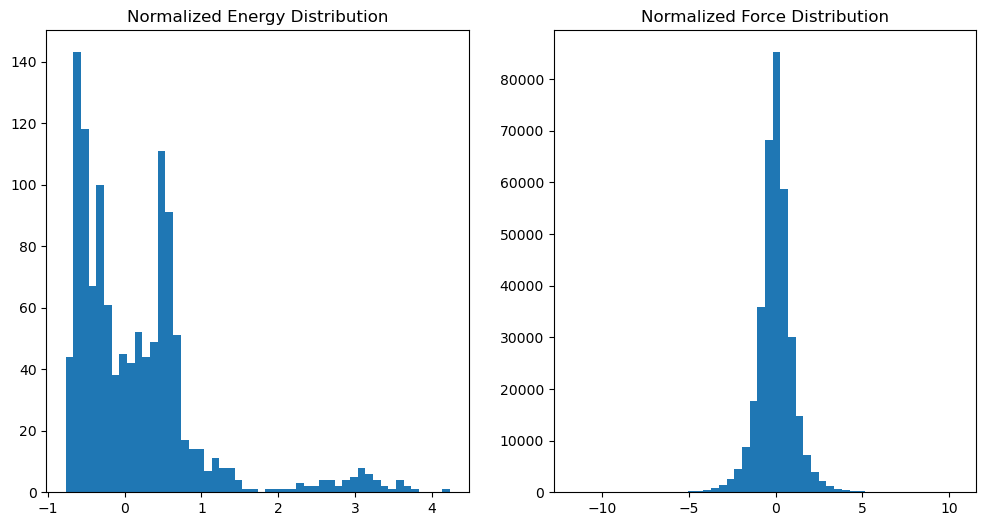

In [20]:
import matplotlib.pyplot as plt

# 정규화된 에너지와 힘 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_energies, bins=50)  # 정규화된 train_energies 사용
plt.title("Normalized Energy Distribution")

plt.subplot(1, 2, 2)
plt.hist(np.concatenate([train_forces[:, i] for i in range(3)]), bins=50)  # 정규화된 train_forces 사용
plt.title("Normalized Force Distribution")

plt.show()


### [Force] Hyperparameter Setting

In [21]:
# 하이퍼파라미터
input_size = 7  # feature 개수
hidden_size = 361
output_size = 3 # target 개수
num_epochs = 3
batch_size = 256
learning_rate = 0.00033834064449587937
dropout_rate = 0.1154893019924863

### [Force] Dataset

In [22]:
class ForceDataset(Dataset):
    def __init__(self, df, mode='test'):
        self.df = df
        self.mode = mode
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        pos_x = self.df.loc[idx, 'position_x']
        pos_y = self.df.loc[idx, 'position_y']
        pos_z = self.df.loc[idx, 'position_z']
        neighbor_count = self.df.loc[idx, 'neighbor_count']
        angle = self.df.loc[idx, 'angle']
        dihedral_angle = self.df.loc[idx, 'dihedral_angle']
        closest_distance = self.df.loc[idx, 'closest_distance']
        inputs = torch.tensor([pos_x, pos_y, pos_z,neighbor_count,
                               angle,dihedral_angle,
                               closest_distance], dtype=torch.float32)
        
        if not self.mode == 'test':
            label = torch.tensor(self.df.loc[idx, 'force'], dtype=torch.float32)
            return inputs, label
        else:
            return inputs

In [23]:
train_dataset = ForceDataset(train_df, 'train')
val_dataset = ForceDataset(val_df, 'train')
test_dataset = ForceDataset(test_df, 'test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### [Force] Model

In [24]:
class ForceModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ForceModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(hidden_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(64, 3)
        )
    
    def forward(self, x):
        y = self.layers(x)
        
        return y

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"current device is {device}")

model = ForceModel(input_size, hidden_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

current device is cpu


### [Force] Train

In [26]:
print("Training Start!")

model.train()
for epoch in range(num_epochs):
    print(f"{epoch+1}/{num_epochs} epoch..")
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

print("Training Complete!")

Training Start!
1/3 epoch..


  0%|          | 0/450 [00:00<?, ?it/s]

2/3 epoch..


  0%|          | 0/450 [00:00<?, ?it/s]

3/3 epoch..


  0%|          | 0/450 [00:00<?, ?it/s]

Training Complete!


### [Force] Inference

In [27]:
# Validation 데이터에 대한 예측
print("Validation Inference Start!")

model.eval()
val_preds = []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred = outputs.detach().cpu().numpy()
        val_preds.extend(pred)

print("Validation Inference Complete!")

Validation Inference Start!


  0%|          | 0/113 [00:00<?, ?it/s]

Validation Inference Complete!


In [28]:
print("Inference Start!")

model.eval()

preds = []
with torch.no_grad():
    for inputs in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)

        pred = outputs.detach().cpu().numpy()
        preds.extend(pred)

print("Inference Complete!")
len(preds)

Inference Start!


  0%|          | 0/1125 [00:00<?, ?it/s]

Inference Complete!


288000

### [Force] Submission

In [29]:
# preds = force_scaler.transform(preds)
preds

[array([-0.00400782, -0.00547486, -0.00821785], dtype=float32),
 array([-0.00855033, -0.01008672, -0.00810369], dtype=float32),
 array([-0.00796683, -0.00468753, -0.00180504], dtype=float32),
 array([-0.0033503 , -0.03244822, -0.02487769], dtype=float32),
 array([ 0.00300149, -0.03452819, -0.02565019], dtype=float32),
 array([-0.02271485, -0.02988402, -0.01523581], dtype=float32),
 array([-0.01551239, -0.02874957, -0.0158247 ], dtype=float32),
 array([-0.02291455, -0.00811622, -0.00717029], dtype=float32),
 array([-0.00607675, -0.03084454, -0.00708153], dtype=float32),
 array([-0.02469097, -0.02007942, -0.00881791], dtype=float32),
 array([-0.00766193, -0.01501816, -0.00053727], dtype=float32),
 array([ 0.00169843, -0.01426182,  0.00855688], dtype=float32),
 array([ 0.01053167, -0.04992822, -0.01381256], dtype=float32),
 array([ 0.00536399, -0.0344517 , -0.02451179], dtype=float32),
 array([ 0.00916544, -0.04669046, -0.02552755], dtype=float32),
 array([ 0.00688803, -0.01832702, -0.011

In [30]:
test_df['force'] = list(preds) # 예측 결과 저장

In [31]:
# 한 분자가 몇 개의 원자로 이루어져 있는지에 따라 범위를 생성
bundles_train,bundles_val, bundles_test = [],[],[]

flag = 0
for size in sequence_train:
    bundles_train.append((flag, flag+size))
    flag += size

flag = 0
for size in sequence_val:
    bundles_val.append((flag, flag+size))
    flag += size

flag = 0
for size in sequence_test:
    bundles_test.append((flag, flag+size))
    flag += size


In [32]:
preds_force = []

for start, end in bundles_test:
    preds_force.append(np.vstack(preds[start:end])) # 2차원 array로 저장

sample['forces'] = preds_force
sample

,ID,energy,energy_uncertainty,forces
0,TEST_0000,0.0,1.0,"[[-0.0040078205, -0.005474858, -0.008217853], ..."
1,TEST_0001,0.0,1.0,"[[-0.002786363, -0.0020263493, -0.009194655], ..."
2,TEST_0002,0.0,1.0,"[[-0.0002479474, -0.011791967, -0.005596474], ..."
3,TEST_0003,0.0,1.0,"[[-0.00083409017, -0.032568, -0.007566901], [0..."
4,TEST_0004,0.0,1.0,"[[0.00543785, -0.01928981, -0.0017464887], [-0..."
...,...,...,...,...
2995,TEST_2995,0.0,1.0,"[[-0.004745835, -0.025344722, 0.0029742252], [..."
2996,TEST_2996,0.0,1.0,"[[-0.0018028705, -0.02034451, 0.0036248136], [..."
2997,TEST_2997,0.0,1.0,"[[-0.0049082837, -0.030159637, 0.0040112007], ..."
2998,TEST_2998,0.0,1.0,"[[-0.0063489857, -0.027640346, -0.00855303], [..."


### [Energy] Preprocessing

In [33]:
print(train_df['force'].head())
print(val_df['force'].head())
print(test_df['force'].head())


0    [-0.14981823630956442, 0.44600123624287996, -2...
1    [-0.22130849375820014, 2.793393386251201, 0.95...
2    [-0.481729915738929, -0.737548817927583, 0.212...
3    [-2.635583123774749, -0.4044080527691283, -0.1...
4    [0.6748454108108357, 2.0768884914861747, -0.87...
Name: force, dtype: object
0    [0.8661819806829528, 0.5645169693312369, -2.90...
1    [0.6346425308550784, 3.971200331199332, -1.243...
2    [2.7966112709817397, 1.8700592993760377, -0.69...
3    [0.3911567982272744, 2.6722119260588038, 1.328...
4    [-0.37257191041575066, -2.2658996321523985, -0...
Name: force, dtype: object
0    [-0.0040078205, -0.005474858, -0.008217853]
1     [-0.008550335, -0.010086715, -0.008103689]
2    [-0.007966831, -0.004687533, -0.0018050373]
3    [-0.0033503002, -0.032448217, -0.024877694]
4      [0.0030014915, -0.03452819, -0.025650192]
Name: force, dtype: object


In [34]:
# 'force' 컬럼의 값을 분해하여 각각의 행으로 만듦
force_df = train_df['force'].apply(pd.Series)
force_df.columns = [f'force{i}' for i in range(3)]

# 분해한 'force' 컬럼을 추가
train_df = train_df.drop('force', axis=1).join(force_df)

force_df = val_df['force'].apply(pd.Series)
force_df.columns = [f'force{i}' for i in range(3)]
val_df = val_df.drop('force', axis=1).join(force_df)

# 'force' 컬럼의 값을 분해하여 각각의 행으로 만듦
force_df = test_df['force'].apply(pd.Series)
force_df.columns = [f'force{i}' for i in range(3)]

# 분해한 'force' 컬럼을 추가
test_df = test_df.drop('force', axis=1).join(force_df)
test_df.head()

,position_x,position_y,position_z,neighbor_count,angle,dihedral_angle,closest_distance,force0,force1,force2
0,-0.341491,-0.067003,0.118278,-0.75,0.034559,0.502289,-0.012656,-0.004008,-0.005475,-0.008218
1,0.979836,-0.330846,0.143798,-0.50,0.744289,0.502289,0.162966,-0.008550,-0.010087,-0.008104
2,-0.340839,-0.399608,-0.531778,-0.50,0.307358,0.273769,-0.033376,-0.007967,-0.004688,-0.001805
3,-0.413464,0.232910,-0.416860,-0.50,-0.781809,0.717775,0.211440,-0.003350,-0.032448,-0.024878
4,-0.508139,-0.910589,-0.970482,-0.25,-1.003868,0.968434,-0.000677,0.003001,-0.034528,-0.025650


In [35]:
# 데이터프레임에서 값 추출
sequences_train = [train_df.iloc[start:end].values for start, end in bundles_train]
sequences_val = [val_df.iloc[start:end].values for start, end in bundles_val]
sequences_test = [test_df.iloc[start:end].values for start, end in bundles_test]

### [Energy] Hyperparameter Setting

In [36]:
# input_size = 10  # feature 개수
# hidden_size = 128
# output_size = 1 # target 개수
# num_epochs = 3
# batch_size = 16
# learning_rate = 0.005986588014174731

### [Energy] Dataset

In [37]:
# 패딩을 사용하여 모든 시퀀스의 길이를 동일하게 만듦
max_len = max(seq.shape[0] for seq in sequences_train)
padded_sequences_train = [np.vstack([seq, np.zeros((max_len - seq.shape[0], 10))]) for seq in sequences_train]

# 패딩된 시퀀스를 2차원 배열로 변환
padded_array_train = np.stack(padded_sequences_train)
X_tensor_train = torch.tensor(padded_array_train, dtype=torch.float32)
y_tensor_train = torch.tensor(train_energies, dtype=torch.float32).view(-1, 1)
train_dataset = TensorDataset(X_tensor_train, y_tensor_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation 패딩
max_len = max(seq.shape[0] for seq in sequences_val)
padded_sequences_val = [np.vstack([seq, np.zeros((max_len - seq.shape[0],10))]) for seq in sequences_val]
padded_array_val = np.stack(padded_sequences_val)
X_tensor_val = torch.tensor(padded_array_val, dtype=torch.float32)
y_tensor_val = torch.tensor(val_energies, dtype=torch.float32).view(-1, 1)
val_energy_dataset = TensorDataset(X_tensor_val, y_tensor_val)
val_energy_loader = DataLoader(val_energy_dataset, batch_size=batch_size, shuffle=False)


# 패딩을 사용하여 모든 시퀀스의 길이를 동일하게 만듦
max_len = max(seq.shape[0] for seq in sequences_test)
padded_sequences_test = [np.vstack([seq, np.zeros((max_len - seq.shape[0], 10))]) for seq in sequences_test]

# 패딩된 시퀀스를 2차원 배열로 변환
padded_array_test = np.stack(padded_sequences_test)
X_tensor_test = torch.tensor(padded_array_test, dtype=torch.float32)
test_dataset = TensorDataset(X_tensor_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### [Energy] Model

In [39]:
import numpy as np
import torch
import optuna
from hyperopt import hp, fmin, tpe, Trials
from sklearn.metrics import mean_squared_error
# BiLSTM 모델 정의
class EnergyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=4, dropout_rate=0.4910892607080616):
        super(EnergyModel, self).__init__()
        
        # Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, 
                            dropout=dropout_rate,
                            bidirectional=True)
        
        # Bidirectional LSTM이므로 hidden_size 조정
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2_mean = nn.Linear(hidden_size, 1)
        self.fc2_variance = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.softplus = nn.Softplus()  
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out[:, -1, :])
        x = self.relu(x)
        x = self.batchnorm(x)
        x = self.dropout(x)

        mean = self.fc2_mean(x)
        variance = self.softplus(self.fc2_variance(x))
        return mean, variance
    
        # 평가를 위한 손실 함수
criterion = nn.GaussianNLLLoss()

# Hyperopt의 탐색 공간 정의
search_space = {
    'hidden_size': hp.quniform('hidden_size', 128, 512, 128),
    'num_layers': hp.quniform('num_layers', 1, 5, 1),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.6),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-1)),
    'batch_size': hp.quniform('batch_size', 16, 256, 16)
}

# Objective 함수 정의
def objective_func(search_space):
    hidden_size = int(search_space['hidden_size'])
    num_layers = int(search_space['num_layers'])
    dropout_rate = search_space['dropout_rate']
    learning_rate = search_space['learning_rate']
    batch_size = int(search_space['batch_size'])
    
    # 모델 초기화
    model = EnergyModel(
        input_size=10,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(device)
    
    # 옵티마이저 설정
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.GaussianNLLLoss()
    # 모델 학습
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(train_loader, leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            mean, variance = model(inputs)
            loss = criterion(mean, labels, variance)

            loss.backward()
            optimizer.step()
    
    # 검증 단계
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_energy_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            mean, variance = model(inputs)
            loss = criterion(mean, labels, variance)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    return val_loss

# Trials 객체 생성
trial_val = Trials()

# 하이퍼파라미터 최적화 수행
best = fmin(
    fn=objective_func,
    space=search_space,
    algo=tpe.suggest,
    max_evals=20,  # 최대 반복 횟수
    trials=trial_val,
    rstate=np.random.default_rng(seed=9)
)

print('Best hyperparameters:', best)
# 최적의 하이퍼파라미터로 모델 학습
best_model = EnergyModel(input_size=10, hidden_size=int(best['hidden_size']), 
                         num_layers=int(best['num_layers']), dropout_rate=best['dropout_rate']).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best['learning_rate'])
train_loader = DataLoader(train_dataset, batch_size=int(best['batch_size']), shuffle=True)

# 최적의 모델 학습
best_model.train()
for epoch in range(num_epochs):
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        mean, variance = best_model(inputs)
        loss = criterion(mean, labels, variance)

        loss.backward()
        optimizer.step()

print("Training with the best parameters complete!")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:36<11:26, 36.15s/trial, best loss: 1130.6057107300885]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 10%|█         | 2/20 [02:02<19:39, 65.53s/trial, best loss: 0.008396655584858583]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 15%|█▌        | 3/20 [03:54<24:34, 86.72s/trial, best loss: 0.008396655584858583]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 4/20 [06:20<29:24, 110.29s/trial, best loss: 0.008396655584858583]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [08:17<28:08, 112.60s/trial, best loss: 0.008396655584858583]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 30%|███       | 6/20 [10:12<26:27, 113.39s/trial, best loss: 0.008396655584858583]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 35%|███▌      | 7/20 [11:14<20:56, 96.62s/trial, best loss: 0.006937441045204095] 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 8/20 [12:29<17:56, 89.70s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 45%|████▌     | 9/20 [14:58<19:50, 108.20s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 50%|█████     | 10/20 [15:23<13:46, 82.64s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 55%|█████▌    | 11/20 [16:26<11:28, 76.55s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 12/20 [17:25<09:30, 71.32s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 65%|██████▌   | 13/20 [18:08<07:19, 62.83s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 70%|███████   | 14/20 [20:21<08:23, 83.99s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 75%|███████▌  | 15/20 [21:09<06:05, 73.16s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 16/20 [21:53<04:16, 64.25s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 85%|████████▌ | 17/20 [22:53<03:09, 63.10s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 90%|█████████ | 18/20 [54:46<20:37, 618.93s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 95%|█████████▌| 19/20 [57:17<07:58, 478.38s/trial, best loss: 0.006937441045204095]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 20/20 [58:18<00:00, 174.95s/trial, best loss: 0.006937441045204095]
Best hyperparameters: {'batch_size': 32.0, 'dropout_rate': 0.5575208672481309, 'hidden_size': 256.0, 'learning_rate': 0.0019086605054417596, 'num_layers': 4.0}


ValueError: batch_size should be a positive integer value, but got batch_size=32.0

In [239]:
# Validation 데이터에 대한 Energy 모델 예측
print("Validation Inference Start!")

best_model.eval()
val_energy_preds_mean = []
val_energy_preds_variance = []
with torch.no_grad():
    for inputs, labels in tqdm(val_energy_loader):
        inputs = inputs.to(device)
        mean, variance = best_model(inputs)
        val_energy_preds_mean.extend(mean.cpu().numpy())
        val_energy_preds_variance.extend(variance.cpu().numpy())

print("Validation Inference Complete!")

In [240]:
print("Inference Start!")

best_model.eval()

preds_mean = []
preds_variance = []
with torch.no_grad():
    for inputs in tqdm(test_loader):
        inputs = inputs[0].to(device)

        mean, variance = best_model(inputs)
        pred_mean = mean.detach().cpu().numpy()
        pred_variance = variance.detach().cpu().numpy()

        preds_mean.extend(pred_mean)
        preds_variance.extend(pred_variance)

print("Inference Complete!")      

In [241]:
# # 모델, 손실 함수, 옵티마이저 초기화
# model = EnergyModel(input_size, hidden_size).to(device)
# criterion = nn.GaussianNLLLoss() 
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### [Energy] Train

In [242]:
# print("Training Start!!")

# # 학습
# model.train()
# for epoch in range(num_epochs):
#     print(f"{epoch+1}/{num_epochs} epoch..")    
#     for inputs, labels in tqdm(train_loader):
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
#         optimizer.zero_grad()
        
#         mean, variance = model(inputs)

#         loss = criterion(mean, labels, variance) 
        
#         loss.backward()
#         optimizer.step()
        
# print("Training Complete!")        

Training Start!!
1/3 epoch..


  0%|          | 0/75 [00:00<?, ?it/s]

2/3 epoch..


  0%|          | 0/75 [00:00<?, ?it/s]

3/3 epoch..


  0%|          | 0/75 [00:00<?, ?it/s]

Training Complete!


### [Energy] Inference

In [243]:
# # Validation 데이터에 대한 Energy 모델 예측
# print("Validation Inference Start!")

# model.eval()
# val_energy_preds_mean = []
# val_energy_preds_variance = []
# with torch.no_grad():
#     for inputs, labels in tqdm(val_energy_loader):
#         inputs = inputs.to(device)
#         mean, variance = model(inputs)
#         val_energy_preds_mean.extend(mean.cpu().numpy())
#         val_energy_preds_variance.extend(variance.cpu().numpy())

# print("Validation Inference Complete!")

Validation Inference Start!


  0%|          | 0/19 [00:00<?, ?it/s]

Validation Inference Complete!


In [244]:
# print("Inference Start!")

# model.eval()

# preds_mean = []
# preds_variance = []
# with torch.no_grad():
#     for inputs in tqdm(test_loader):
#         inputs = inputs[0].to(device)

#         mean, variance = model(inputs)
#         pred_mean = mean.detach().cpu().numpy()
#         pred_variance = variance.detach().cpu().numpy()

#         preds_mean.extend(pred_mean)
#         preds_variance.extend(pred_variance)

# print("Inference Complete!")      

Inference Start!


  0%|          | 0/188 [00:00<?, ?it/s]

Inference Complete!


In [245]:
print(np.array(val_energy_preds_mean).shape)  # val_preds의 현재 형태 출력

(300, 1)


In [246]:
import numpy as np

def calculate_ef_metric(true_energy, pred_energy, true_forces, pred_forces, lambda_force=1/25):
    # 각 분자의 원자 수를 계산합니다.
    num_atoms = true_forces.shape[1]  # 각 분자의 원자 수
    
    # RMSE of per-atom energy
    per_atom_energy_rmse = np.sqrt(np.mean(((true_energy - pred_energy) / num_atoms)**2))
    
    # Axis-wise RMSE of force
    force_rmse_sum = 0.0
    for i in range(3):  # x, y, z components
        force_rmse_sum += np.sum((true_forces[:, :, i] - pred_forces[:, :, i])**2)
    
    axis_wise_rmse = np.sqrt(force_rmse_sum / (true_forces.shape[0] * true_forces.shape[1] * 3))
    
    # EF Metric
    ef_score = (per_atom_energy_rmse + lambda_force * axis_wise_rmse) * 1000
    return ef_score

# Validation 데이터에 대한 EF Metric 계산
num_atoms = val_df['force0'].shape[0] // len(val_energy_preds_mean)  # 각 분자의 원자 수 계산
val_forces_array = np.array(val_df[['force0', 'force1', 'force2']].values).reshape(-1, num_atoms, 3)
val_preds_array = np.array(val_preds).reshape(-1, num_atoms, 3)
val_score = calculate_ef_metric(val_energies, val_energy_preds_mean, val_forces_array, val_preds_array)

print(f"Validation EF Metric: {val_score}")


Validation EF Metric: 50.847143534981356


### [Energy] Submission

In [247]:
preds_mean = [pred.item() for pred in preds_mean]
preds_variance = [pred.item() for pred in preds_variance]

In [248]:
sample['energy'] = preds_mean
sample['energy_uncertainty'] = preds_variance

sample

,ID,energy,energy_uncertainty,forces
0,TEST_0000,-0.039594,0.536016,"[[0.01675819, 0.009011753, 0.0035758042], [0.0..."
1,TEST_0001,-0.039992,0.535589,"[[0.010732688, -0.0016508824, 0.0036684196], [..."
2,TEST_0002,-0.033123,0.535309,"[[0.023862906, 0.008421438, 0.010825837], [0.0..."
3,TEST_0003,-0.029429,0.534812,"[[0.0024974537, 0.0011070627, -0.008245848], [..."
4,TEST_0004,-0.032226,0.535693,"[[0.028314818, 0.006912336, -0.0122824125], [-..."
...,...,...,...,...
2995,TEST_2995,-0.033936,0.534837,"[[0.015312366, 0.011079263, -0.005342346], [-0..."
2996,TEST_2996,-0.033246,0.535203,"[[0.013331253, 0.0025928621, -0.01097922], [0...."
2997,TEST_2997,-0.032769,0.535456,"[[0.0049925977, 0.0012957458, -0.0038543926], ..."
2998,TEST_2998,-0.043547,0.533102,"[[0.018563312, 0.0015654564, -0.0132685285], [..."


In [249]:
# sample['energy'] = energy_scaler.transform(sample['energy'])

In [250]:
import ast
import numpy as np

# 문자열을 리스트로 변환 (리스트나 배열이 아닌 경우에만)
sample['forces'] = sample['forces'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else np.array(x))

# 각 force 성분을 역변환
forces_reshaped = np.concatenate(sample['forces'].tolist()).reshape(-1, 3)
forces_original_scale = force_scaler.inverse_transform(forces_reshaped)

# 다시 원래 형태로 재조합 (분자별로 다시 3차원으로 변환)
forces_original_scale = np.array(np.split(forces_original_scale, len(sample)))

# 역변환된 값을 다시 sample['forces']에 저장
sample['forces'] = [f.tolist() for f in forces_original_scale]

# 에너지도 역변환 (energy는 2D 배열이어야 함)
sample['energy'] = energy_scaler.inverse_transform(np.array(sample['energy']).reshape(-1, 1)).flatten()

sample.head()


,ID,energy,energy_uncertainty,forces
0,TEST_0000,-925.354021,0.536016,"[[0.032425858080387115, 0.01725004054605961, 0..."
1,TEST_0001,-925.370440,0.535589,"[[0.02076796069741249, -0.0031546768732368946,..."
2,TEST_0002,-925.086839,0.535309,"[[0.04617176949977875, 0.01612037420272827, 0...."
3,TEST_0003,-924.934334,0.534812,"[[0.0048347655683755875, 0.002123107435181737,..."
4,TEST_0004,-925.049794,0.535693,"[[0.054785147309303284, 0.0132324593141675, -0..."


In [251]:
# forces 열의 numpy 배열을 리스트로 변환 후 문자열로 저장
sample['forces'] = sample['forces'].apply(lambda x: str(np.array(x).tolist()))

In [252]:
sample.to_csv('피쳐 여러개 추가+ 학습 하이퍼파라미터 튜닝.csv', index=False)